In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import os
import json
import sys
import numpy as np
sys.path.append("..")
import copy

In [3]:
from src import models, data, operators, utils, functional, metrics, lens
from src.utils import logging_utils
import logging
import torch
import baukit

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format = logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout
)

In [4]:
mt = models.load_model(name = "gptj", fp16 = True, device = "cuda")

2023-06-14 15:09:17 src.models INFO     loading EleutherAI/gpt-j-6B (device=cuda, fp16=True)


In [5]:
relation = data.load_dataset().filter(relation_names=["country capital city"])[0].set(prompt_templates=[" {}:"])
train, test = relation.split(5)

In [6]:
icl_prompt = functional.make_prompt(
    prompt_template = train.prompt_templates[0],
    subject = "{}",
    examples = train.samples,
    mt = mt
)
print(icl_prompt)

<|endoftext|> India: New Delhi
 South Korea: Seoul
 France: Paris
 Colombia: Bogot\u00e1
 Russia: Moscow
 {}:


In [7]:
test = functional.filter_relation_samples_based_on_provided_fewshots(
    mt = mt, 
    test_relation=test,
    prompt_template = icl_prompt,
    batch_size=4
)
len(test.samples)

14

### Current Method => Calculate $b_r$ and $W_r$ individually and average them.

In [8]:
estimator = operators.JacobianIclMeanEstimator(
    mt = mt, h_layer=7, beta=0.2
)
operator = estimator(train)

India -> New Delhi | z_norm=294.25 | z_proj=21.765625 || o_pred=([(' Houston', 0.142), (' Toronto', 0.142), (' Tai', 0.093)], {})
South Korea -> Seoul | z_norm=270.0 | z_proj=23.640625 || o_pred=([('Tok', 0.136), (' inter', 0.051), (' San', 0.049)], {})
France -> Paris | z_norm=270.75 | z_proj=21.78125 || o_pred=([(' Pal', 0.102), (' Rome', 0.037), (' Lisbon', 0.03)], {})
Colombia -> Bogot\u00e1 | z_norm=241.875 | z_proj=29.265625 || o_pred=([(' wherever', 0.042), (' where', 0.036), (' back', 0.026)], {})
Russia -> Moscow | z_norm=280.75 | z_proj=21.890625 || o_pred=([(' Hungarian', 0.15), (' Taiwanese', 0.097), (' Hungary', 0.062)], {})

projection with mean weight
India -> New Delhi | z_norm=294.25 | z_proj=42.03125 || o_pred=([(' Delhi', 0.818), (' India', 0.122), (' Indian', 0.041)], {})
South Korea -> Seoul | z_norm=270.0 | z_proj=38.34375 || o_pred=([(' Seoul', 0.992), (' Korean', 0.008), (' Koreans', 0.0)], {})
France -> Paris | z_norm=270.75 | z_proj=36.34375 || o_pred=([(' Par

In [19]:
# calculate faithfulness
def evaluate_operator(operator, test_samples):
    pred_objects = []
    test_objects = []
    for sample in test_samples:
        test_objects.append(sample.object)
        preds = operator(sample.subject, k=3)
        pred = str(preds.predictions[0])
        print(f"{sample.subject=} -> {sample.object=} | {pred=}")
        pred_objects.append([p.token for p in preds.predictions])

    recall = metrics.recall(pred_objects, test_objects)
    return recall

evaluate_operator(operator, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Buenos (p=0.896)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Santiago (p=0.976)'
sample.subject='China' -> sample.object='Beijing' | pred=' Beijing (p=0.936)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Cairo (p=0.947)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=0.950)'
sample.subject='Italy' -> sample.object='Rome' | pred=' Rome (p=0.731)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=0.977)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Mexico (p=0.987)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Islamabad (p=0.862)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Lima (p=0.970)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' Riyadh (p=0.617)'
sample.subject='Spain' -> sample.object='Madrid' | pred=' Madrid (p=0.927)'
sample.subject='United States' -> sample.object='Washington D

[1.0, 1.0, 1.0]

In [20]:
lens.logit_lens(mt = mt, h = operator.bias, get_proba=True, k = 10)

([(' New', 0.229),
  (' ', 0.195),
  (' Moscow', 0.061),
  ('\n', 0.053),
  (' Paris', 0.046),
  (' K', 0.02),
  (' N', 0.019),
  (' London', 0.014),
  (' S', 0.013),
  (' M', 0.013)],
 {})

In [43]:
1/.00002

49999.99999999999

### Get rid of the $\beta$ by setting $\beta = 1$

In [66]:
# operator_dct = deepcopy(operator.__dict__)

# set beta and omega such that beta/omega = c
c = 0.2
beta = 0.0002
omega = beta/c

omega = 5
beta = omega * c

operator_dct = operator.__dict__.copy()
operator_dct["beta"] = beta
operator_dct["weight"] = operator.weight * omega
operator_no_beta = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_no_beta, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Buenos (p=0.012)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Santiago (p=0.023)'
sample.subject='China' -> sample.object='Beijing' | pred=' Beijing (p=0.100)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Cairo (p=0.010)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=0.021)'
sample.subject='Italy' -> sample.object='Rome' | pred=' Rome (p=0.016)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=0.119)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Mexico (p=0.025)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Islamabad (p=0.026)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Lima (p=0.007)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred='  (p=0.007)'
sample.subject='Spain' -> sample.object='Madrid' | pred=' Madrid (p=0.013)'
sample.subject='United States' -> sample.object='Washington D.C.' |

[0.8571428571428571, 0.9285714285714286, 0.9285714285714286]

In [49]:
1 / operator_dct["beta"]

5.0

In [22]:
hs_and_zs = functional.compute_hs_and_zs(
    mt = mt,
    prompt_template = train.prompt_templates[0],
    subjects = [sample.subject for sample in relation.samples],
    h_layer= operator.h_layer,
    z_layer=-1,
    batch_size=4,
    examples= train.samples
)

In [23]:
for sample in train.samples:
    subj = sample.subject
    obj = sample.object
    pred = functional.predict_next_token(
        mt = mt,
        prompt = functional.make_prompt(
            prompt_template = train.prompt_templates[0],
            subject = subj,
            examples = train.samples,
            mt = mt
        )
    )[0][0]
    h_norm = hs_and_zs.h_by_subj[subj].norm().item()
    z_norm = hs_and_zs.z_by_subj[subj].norm().item()
    print(f"{subj=} -> {obj=} | {h_norm=} | {z_norm=} || {pred=}")

subj='India' -> obj='New Delhi' | h_norm=69.5625 | z_norm=294.25 || pred=PredictedToken(token=' New', prob=0.6054127812385559)
subj='South Korea' -> obj='Seoul' | h_norm=68.375 | z_norm=270.0 || pred=PredictedToken(token=' Seoul', prob=0.9704020023345947)
subj='France' -> obj='Paris' | h_norm=70.875 | z_norm=270.75 || pred=PredictedToken(token=' Paris', prob=0.9210968613624573)
subj='Colombia' -> obj='Bogot\\u00e1' | h_norm=76.8125 | z_norm=242.125 || pred=PredictedToken(token=' Bog', prob=0.8252081274986267)
subj='Russia' -> obj='Moscow' | h_norm=68.1875 | z_norm=280.5 || pred=PredictedToken(token=' Moscow', prob=0.9483776688575745)


In [31]:
h_norms = []
jh_norms = []
for subj in hs_and_zs.h_by_subj.keys():
    h = hs_and_zs.h_by_subj[subj]
    jh = operator.weight @ h
    h_norms.append(h.norm().item())
    jh_norms.append(jh.norm().item())
    print(f"{subj=} | {h.norm()=} | {jh.norm()=} | {h.mean()=} | {h.std()=}")

print(f"h_norms: {np.mean(h_norms):.2f} +/- {np.std(h_norms):.2f}")
print(f"jh_norms: {np.mean(jh_norms):.2f} +/- {np.std(jh_norms):.2f}")

subj='United States' | h.norm()=tensor(66.8125, device='cuda:0', dtype=torch.float16) | jh.norm()=tensor(40.4062, device='cuda:0', dtype=torch.float16) | h.mean()=tensor(0.0115, device='cuda:0', dtype=torch.float16) | h.std()=tensor(1.0439, device='cuda:0', dtype=torch.float16)
subj='Canada' | h.norm()=tensor(68.1250, device='cuda:0', dtype=torch.float16) | jh.norm()=tensor(47.6250, device='cuda:0', dtype=torch.float16) | h.mean()=tensor(0.0131, device='cuda:0', dtype=torch.float16) | h.std()=tensor(1.0645, device='cuda:0', dtype=torch.float16)
subj='Mexico' | h.norm()=tensor(68.7500, device='cuda:0', dtype=torch.float16) | jh.norm()=tensor(46.7500, device='cuda:0', dtype=torch.float16) | h.mean()=tensor(0.0131, device='cuda:0', dtype=torch.float16) | h.std()=tensor(1.0742, device='cuda:0', dtype=torch.float16)
subj='Brazil' | h.norm()=tensor(69.3125, device='cuda:0', dtype=torch.float16) | jh.norm()=tensor(44.5000, device='cuda:0', dtype=torch.float16) | h.mean()=tensor(0.0148, device

### $b_r = \mathbf{o}_{mean} - J\mathbf{s}_{mean}$

In [14]:
z_mean = torch.stack([hs_and_zs.z_by_subj[sample.subject] for sample in train.samples]).mean(dim = 0)
h_mean = torch.stack([hs_and_zs.h_by_subj[sample.subject] for sample in train.samples]).mean(dim = 0)

bias_mean = z_mean - operator.weight @ h_mean
print(torch.dist(bias_mean, operator.bias))

tensor(23.8281, device='cuda:0', dtype=torch.float16, grad_fn=<DistBackward0>)


In [15]:
operator_dct = operator.__dict__.copy()
operator_dct["beta"] = 1 #.2
operator_dct["bias"] = bias_mean
operator_bias_J = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_bias_J, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Buenos (p=0.199)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Santiago (p=0.153)'
sample.subject='China' -> sample.object='Beijing' | pred=' Moscow (p=0.200)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Moscow (p=0.173)'
sample.subject='France' -> sample.object='Paris' | pred=' Paris (p=0.527)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=0.196)'
sample.subject='India' -> sample.object='New Delhi' | pred=' New (p=0.187)'
sample.subject='Italy' -> sample.object='Rome' | pred=' Rome (p=0.268)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Moscow (p=0.205)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Mexico (p=0.281)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Moscow (p=0.172)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Moscow (p=0.223)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' Mosc

[0.5, 0.625, 0.625]

### $b_r = F(\mathbf{s}_{mean}) -J\mathbf{s}_{mean}$

In [16]:
h_layer_name, z_layer_name = models.determine_layer_paths(mt, layers = [operator.h_layer, operator.z_layer])

In [17]:
hs_and_zs.h_by_subj.keys()

dict_keys(['United States', 'Canada', 'Mexico', 'Brazil', 'Argentina', 'Chile', 'Peru', 'Colombia', 'Venezuela', 'Spain', 'France', 'Germany', 'Italy', 'Russia', 'China', 'Japan', 'South Korea', 'India', 'Pakistan', 'Nigeria', 'Egypt', 'Saudi Arabia', 'Turkey', 'Australia'])

In [18]:
def get_intervention(h, int_layer, subj_idx):
    def edit_output(output, layer):
        if(layer != int_layer):
            return output
        functional.untuple(output)[:, subj_idx] = h
        return output
    return edit_output

subject = "Russia"
prompt = icl_prompt.format(subject)

h_index, inputs = functional.find_subject_token_index(
    mt=mt,
    prompt=prompt,
    subject=subject,
)

with baukit.TraceDict(
    mt.model, layers = [h_layer_name, z_layer_name],
    edit_output=get_intervention(h_mean, h_layer_name, h_index)
) as traces:
    outputs = mt.model(
        input_ids = inputs.input_ids,
        attention_mask = inputs.attention_mask,
    )

lens.interpret_logits(
    mt = mt, 
    logits = outputs.logits[0][-1], 
    get_proba=True
)

[(' Bog', 0.637),
 (' Mexico', 0.072),
 (' Madrid', 0.032),
 (' Barcelona', 0.024),
 (' Colombia', 0.02),
 (' Havana', 0.018),
 (' Car', 0.017),
 (' Buenos', 0.011),
 (' Moscow', 0.011),
 (' Med', 0.01)]

In [19]:
s = functional.untuple(traces[h_layer_name].output)[0][h_index]
s.shape

torch.Size([4096])

In [40]:
s.norm().item()

62.59375

In [42]:
h_mean.norm().item()

62.59375

In [20]:
z_mean_F = traces[z_layer_name].output[0][-1][-1]
# lens.logit_lens(mt = mt, h = z_mean_F, get_proba=True)
bias_F = z_mean_F - operator.weight @ h_mean
print(torch.dist(bias_F, operator.bias))
lens.logit_lens(mt = mt, h = bias_F, get_proba=True)

tensor(80.3125, device='cuda:0', dtype=torch.float16, grad_fn=<DistBackward0>)


([(' Bog', 0.656),
  (' Mexico', 0.056),
  (' Madrid', 0.025),
  (' Colombia', 0.019),
  (' Havana', 0.019),
  (' Car', 0.018),
  (' Barcelona', 0.016),
  (' Moscow', 0.015),
  (' Buenos', 0.012),
  (' Med', 0.011)],
 {})

In [21]:
operator_dct = operator.__dict__.copy()
operator_dct["beta"] = 1 #.2
operator_dct["bias"] = bias_F
operator_bias_J = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_bias_J, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Bog (p=0.464)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Bog (p=0.472)'
sample.subject='China' -> sample.object='Beijing' | pred=' Bog (p=0.471)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Bog (p=0.472)'
sample.subject='France' -> sample.object='Paris' | pred=' Bog (p=0.487)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Bog (p=0.483)'


sample.subject='India' -> sample.object='New Delhi' | pred=' Bog (p=0.546)'
sample.subject='Italy' -> sample.object='Rome' | pred=' Bog (p=0.524)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Bog (p=0.436)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Mexico (p=0.764)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Bog (p=0.523)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Bog (p=0.485)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' Bog (p=0.560)'
sample.subject='South Korea' -> sample.object='Seoul' | pred=' Bog (p=0.609)'
sample.subject='United States' -> sample.object='Washington D.C.' | pred=' Bog (p=0.560)'
sample.subject='Venezuela' -> sample.object='Caracas' | pred=' Bog (p=0.456)'


[0.0625, 0.25, 0.3125]

### Make all the $|\mathbf{o}|$ similar

In [22]:
z_s = torch.stack([hs_and_zs.z_by_subj[sample.subject] for sample in train.samples])
min_norm = z_s.norm(dim = 1).min()
z_s = torch.stack([(z*min_norm)/z.norm() for z in z_s])

z_mean = z_s.mean(dim = 0)
bias_mean = z_mean - operator.weight @ h_mean

print(torch.dist(bias_mean, operator.bias))
lens.logit_lens(mt = mt, h = bias_mean, get_proba=True)

tensor(36.2500, device='cuda:0', dtype=torch.float16, grad_fn=<DistBackward0>)


([(' Moscow', 0.312),
  (' ', 0.049),
  ('\n', 0.044),
  (' New', 0.03),
  (' Paris', 0.026),
  (' London', 0.021),
  (' Washington', 0.021),
  (' Madrid', 0.021),
  (' Bog', 0.02),
  (' T', 0.015)],
 {})

In [23]:
operator_dct = operator.__dict__.copy()
operator_dct["beta"] = 1 #.2
operator_dct["bias"] = bias_mean
operator_similar_o = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_similar_o, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Buenos (p=0.265)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Santiago (p=0.210)'
sample.subject='China' -> sample.object='Beijing' | pred=' Beijing (p=0.258)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Moscow (p=0.168)'
sample.subject='France' -> sample.object='Paris' | pred=' Paris (p=0.605)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=0.247)'
sample.subject='India' -> sample.object='New Delhi' | pred=' New (p=0.210)'
sample.subject='Italy' -> sample.object='Rome' | pred=' Rome (p=0.326)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=0.208)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Mexico (p=0.358)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Moscow (p=0.167)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Moscow (p=0.219)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' Mosc

[0.625, 0.625, 0.625]

### Automatically *tune* $\beta$ for each training sample 

In [24]:
training_hs = torch.stack([hs_and_zs.h_by_subj[sample.subject] for sample in train.samples])
training_zs = torch.stack([hs_and_zs.z_by_subj[sample.subject] for sample in train.samples])

biases = []
for sample in train.samples:
    subj = sample.subject
    obj = sample.object
    h = hs_and_zs.h_by_subj[subj]
    z = hs_and_zs.z_by_subj[subj]
    b_sample = z - operator.weight @ h
    print(f"{subj=} | h_norm={h.norm()} | z_norm={z.norm()} || b_norm={b_sample.norm()}")
    for beta in np.linspace(0, 1, 10):
        z_est = operator.weight @ h + b_sample * beta
        pred, _ = lens.logit_lens(mt = mt, h = z_est, get_proba=True, k = 3)
        print(f"{obj=} | {beta=} | z_est={z_est.norm()} | {pred=}")
        top_token = pred[0][0]
        if functional.is_nontrivial_prefix(prediction=top_token, target=sample.object):
            biases.append(b_sample * beta)
            break
    print()

subj='Colombia' | h_norm=76.25 | z_norm=242.125 || b_norm=232.125
obj='Bogot\\u00e1' | beta=0.0 | z_est=44.15625 | pred=[(' Colombian', 0.284), (' Colombia', 0.091), (' Bog', 0.062)]
obj='Bogot\\u00e1' | beta=0.1111111111111111 | z_est=54.125 | pred=[(' Bog', 0.826), (' Colombia', 0.088), (' Colombian', 0.023)]

subj='Canada' | h_norm=69.3125 | z_norm=279.0 || b_norm=261.5
obj='Ottawa' | beta=0.0 | z_est=41.71875 | pred=[(' Canada', 0.425), (' Toronto', 0.306), (' Quebec', 0.134)]
obj='Ottawa' | beta=0.1111111111111111 | z_est=58.6875 | pred=[(' Toronto', 0.526), (' Canada', 0.156), (' Ottawa', 0.142)]
obj='Ottawa' | beta=0.2222222222222222 | z_est=82.6875 | pred=[(' Toronto', 0.523), (' Ottawa', 0.189), (' Montreal', 0.101)]
obj='Ottawa' | beta=0.3333333333333333 | z_est=109.125 | pred=[(' Toronto', 0.488), (' Ottawa', 0.217), (' Montreal', 0.12)]
obj='Ottawa' | beta=0.4444444444444444 | z_est=136.75 | pred=[(' Toronto', 0.464), (' Ottawa', 0.226), (' Montreal', 0.129)]
obj='Ottawa' |

In [25]:
operator = estimator(train)

Colombia -> Bogot\u00e1 | z_norm=242.125 | z_proj=34.78125 || o_pred=([(' back', 0.026), (' where', 0.018), (' wherever', 0.017)], {})
Canada -> Ottawa | z_norm=279.0 | z_proj=21.890625 || o_pred=([('\\', 0.018), (' routine', 0.017), (' command', 0.015)], {})
Spain -> Madrid | z_norm=265.25 | z_proj=21.296875 || o_pred=([(' Moscow', 0.043), (' National', 0.026), (' Rome', 0.019)], {})
Turkey -> Ankara | z_norm=268.0 | z_proj=20.640625 || o_pred=([(' New', 0.374), (' Roma', 0.031), (' Buddh', 0.019)], {})
Russia -> Moscow | z_norm=257.5 | z_proj=20.40625 || o_pred=([(' La', 0.216), (' Cas', 0.032), (' Cal', 0.026)], {})

projection with mean weight
Colombia -> Bogot\u00e1 | z_norm=242.125 | z_proj=44.1875 || o_pred=([(' Colombian', 0.283), (' Colombia', 0.09), (' Bog', 0.061)], {})
Canada -> Ottawa | z_norm=279.0 | z_proj=41.75 || o_pred=([(' Canada', 0.425), (' Toronto', 0.306), (' Quebec', 0.134)], {})
Spain -> Madrid | z_norm=265.25 | z_proj=42.28125 || o_pred=([(' Madrid', 0.545), (

In [26]:
biases = []
for sample, approx in zip(train.samples, operator.metadata["approxes"]):
    subj = sample.subject
    obj = sample.object
    h = approx.h
    z = approx.z
    print(f"{subj=} | h_norm={h.norm()} | z_norm={z.norm()} || b_norm={approx.bias.norm()}")
    for beta in np.linspace(0, 1, 10):
        z_est = approx.weight @ h + approx.bias * beta
        pred, _ = lens.logit_lens(mt = mt, h = z_est, get_proba=True, k = 3)
        print(f"{obj=} | {beta=} | z_est={z_est.norm()} | {pred=}")
        top_token = pred[0][0]
        if functional.is_nontrivial_prefix(prediction=top_token, target=sample.object):
            biases.append(b_sample * beta)
            break
    print()

subj='Colombia' | h_norm=76.25 | z_norm=242.125 || b_norm=254.375
obj='Bogot\\u00e1' | beta=0.0 | z_est=34.78125 | pred=[(' back', 0.026), (' where', 0.018), (' wherever', 0.017)]
obj='Bogot\\u00e1' | beta=0.1111111111111111 | z_est=34.59375 | pred=[(' New', 0.185), (' Amsterdam', 0.068), (' NY', 0.056)]
obj='Bogot\\u00e1' | beta=0.2222222222222222 | z_est=52.71875 | pred=[(' Bog', 0.44), (' New', 0.154), (' Madrid', 0.047)]

subj='Canada' | h_norm=69.3125 | z_norm=279.0 || b_norm=276.25
obj='Ottawa' | beta=0.0 | z_est=21.890625 | pred=[('\\', 0.018), (' routine', 0.017), (' command', 0.015)]
obj='Ottawa' | beta=0.1111111111111111 | z_est=39.15625 | pred=[(' Toronto', 0.263), (' Vancouver', 0.191), (' Montreal', 0.105)]
obj='Ottawa' | beta=0.2222222222222222 | z_est=66.875 | pred=[(' Toronto', 0.376), (' Ottawa', 0.164), (' Vancouver', 0.154)]
obj='Ottawa' | beta=0.3333333333333333 | z_est=96.4375 | pred=[(' Toronto', 0.384), (' Ottawa', 0.193), (' Montreal', 0.146)]
obj='Ottawa' | bet

In [27]:
b_mean = torch.stack(biases).mean(dim = 0)

operator_dct = operator.__dict__.copy()
operator_dct["beta"] = 1 #.2
operator_dct["bias"] = b_mean
operator_auto_beta = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_auto_beta, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Buenos (p=0.964)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Santiago (p=0.995)'
sample.subject='China' -> sample.object='Beijing' | pred=' Beijing (p=0.944)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Cairo (p=0.854)'
sample.subject='France' -> sample.object='Paris' | pred=' Paris (p=0.930)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=0.895)'
sample.subject='India' -> sample.object='New Delhi' | pred=' Delhi (p=0.649)'
sample.subject='Italy' -> sample.object='Rome' | pred=' Rome (p=0.820)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=0.974)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Mexico (p=0.983)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Islamabad (p=0.982)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Lima (p=0.942)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' Ri

[0.9375, 0.9375, 0.9375]

### Drop $J\mathbf{s}$ entirely from bias estimation. (basically the corner method?)

In [28]:
biases = torch.stack([approx.bias[0] for approx in operator.metadata["approxes"]])
min_norm = biases.norm(dim = 1).min()

biases = torch.stack([(b*min_norm)/b.norm() for b in biases])
b_mean = biases.mean(dim = 0)

print(torch.dist(b_mean, operator.bias))
lens.logit_lens(mt = mt, h = b_mean, get_proba=True)

tensor(6.6914, device='cuda:0', dtype=torch.float16, grad_fn=<DistBackward0>)


([(' Moscow', 0.195),
  (' ', 0.076),
  ('\n', 0.072),
  (' Bog', 0.038),
  (' Madrid', 0.031),
  (' New', 0.025),
  (' London', 0.019),
  (' Washington', 0.018),
  (' Paris', 0.017),
  (' San', 0.016)],
 {})

In [29]:
b_mean.norm().item(), operator.bias.norm().item()

(231.25, 237.75)

In [30]:
operator_dct = operator.__dict__.copy()
operator_dct["beta"] = .2 #.2
operator_dct["bias"] = b_mean
operator_dropped_js = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_dropped_js, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Buenos (p=0.966)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Santiago (p=0.996)'
sample.subject='China' -> sample.object='Beijing' | pred=' Beijing (p=0.956)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Cairo (p=0.910)'
sample.subject='France' -> sample.object='Paris' | pred=' Paris (p=0.951)'


sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=0.921)'
sample.subject='India' -> sample.object='New Delhi' | pred=' Delhi (p=0.581)'
sample.subject='Italy' -> sample.object='Rome' | pred=' Rome (p=0.890)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=0.986)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Mexico (p=0.992)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Islamabad (p=0.960)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Lima (p=0.948)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' Riyadh (p=0.564)'
sample.subject='South Korea' -> sample.object='Seoul' | pred=' Seoul (p=0.998)'
sample.subject='United States' -> sample.object='Washington D.C.' | pred=' Washington (p=0.878)'
sample.subject='Venezuela' -> sample.object='Caracas' | pred=' Car (p=0.900)'


[0.9375, 0.9375, 0.9375]

In [31]:
translation_estimator = operators.OffsetEstimatorBaseline(
    mt = mt,
    h_layer = operator.h_layer,
    z_layer=operator.z_layer,
    mode = "icl",
)

translation = translation_estimator(
    relation.set(
        samples = train.samples + test.samples
    )
)
corner = translation.bias

print(torch.dist(corner, operator.bias))
lens.logit_lens(mt = mt, h = corner, get_proba=True)

tensor(235.1250, device='cuda:0', dtype=torch.float16, grad_fn=<DistBackward0>)


([(' Moscow', 0.666),
  (' Paris', 0.216),
  (' Madrid', 0.055),
  (' Tokyo', 0.023),
  (' Beijing', 0.023),
  (' Berlin', 0.018),
  (' London', 0.0),
  (' Washington', 0.0),
  (' Cairo', 0.0),
  (' Rome', 0.0)],
 {})

In [32]:
evaluate_operator(translation, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Paris (p=0.702)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Paris (p=0.501)'
sample.subject='China' -> sample.object='Beijing' | pred=' Paris (p=0.423)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Beijing (p=0.541)'


sample.subject='France' -> sample.object='Paris' | pred=' Paris (p=0.657)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Paris (p=0.355)'
sample.subject='India' -> sample.object='New Delhi' | pred=' Berlin (p=0.245)'
sample.subject='Italy' -> sample.object='Rome' | pred=' Paris (p=0.682)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Paris (p=0.761)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Paris (p=0.454)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Beijing (p=0.371)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Paris (p=0.359)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' Beijing (p=0.370)'
sample.subject='South Korea' -> sample.object='Seoul' | pred=' Paris (p=0.451)'
sample.subject='United States' -> sample.object='Washington D.C.' | pred=' Paris (p=0.556)'
sample.subject='Venezuela' -> sample.object='Caracas' | pred=' Paris (p=0.413)'


[0.0625, 0.0625, 0.0625]

In [33]:
operator_dct = operator.__dict__.copy()
operator_dct["beta"] = 1 #.2
operator_dct["bias"] = corner
operator_corner = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_corner, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Buenos (p=1.000)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Santiago (p=0.994)'
sample.subject='China' -> sample.object='Beijing' | pred=' Beijing (p=1.000)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Cairo (p=1.000)'
sample.subject='France' -> sample.object='Paris' | pred=' Paris (p=1.000)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=1.000)'
sample.subject='India' -> sample.object='New Delhi' | pred=' Delhi (p=0.989)'
sample.subject='Italy' -> sample.object='Rome' | pred=' Rome (p=1.000)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=1.000)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Mexico (p=1.000)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Islamabad (p=0.939)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Lima (p=0.837)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' To

[0.8125, 0.875, 0.875]

In [34]:
from scripts.explain_beta import TrialResult, AllTrialResults

In [35]:
beta_path = "../results/explain_beta/gptj"

results = {}
for relation_folder in os.listdir(beta_path):
    relation_path = os.path.join(beta_path, relation_folder)
    for n_train in os.listdir(relation_path):
        n_train_path = os.path.join(relation_path, n_train)
        for file in os.listdir(n_train_path):
            with open(f"{n_train_path}/{file}") as f:
                data = json.load(f)
                data = AllTrialResults.from_dict(data)
                if(data.relation_name not in results):
                    results[data.relation_name] = {}
                _n_train = len(data.trials[0].train_samples)
                if _n_train not in results[data.relation_name]:
                    results[data.relation_name][_n_train] = data                   
                else:
                    results[data.relation_name][_n_train].trials.extend(data.trials)

In [36]:
relations = list(results.keys())
relation = relations[0]
# relations

In [37]:
train_options = sorted(list(results[relation].keys()))
train_options

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [38]:
bias_norms = [
    np.array([trial.bias_norm for trial in results[relation][n_train].trials])
    for n_train in train_options
]

means = np.array([np.mean(bias_norm) for bias_norm in bias_norms])
stds = np.array([np.std(bias_norm) for bias_norm in bias_norms])

Text(0, 0.5, 'bias norm')

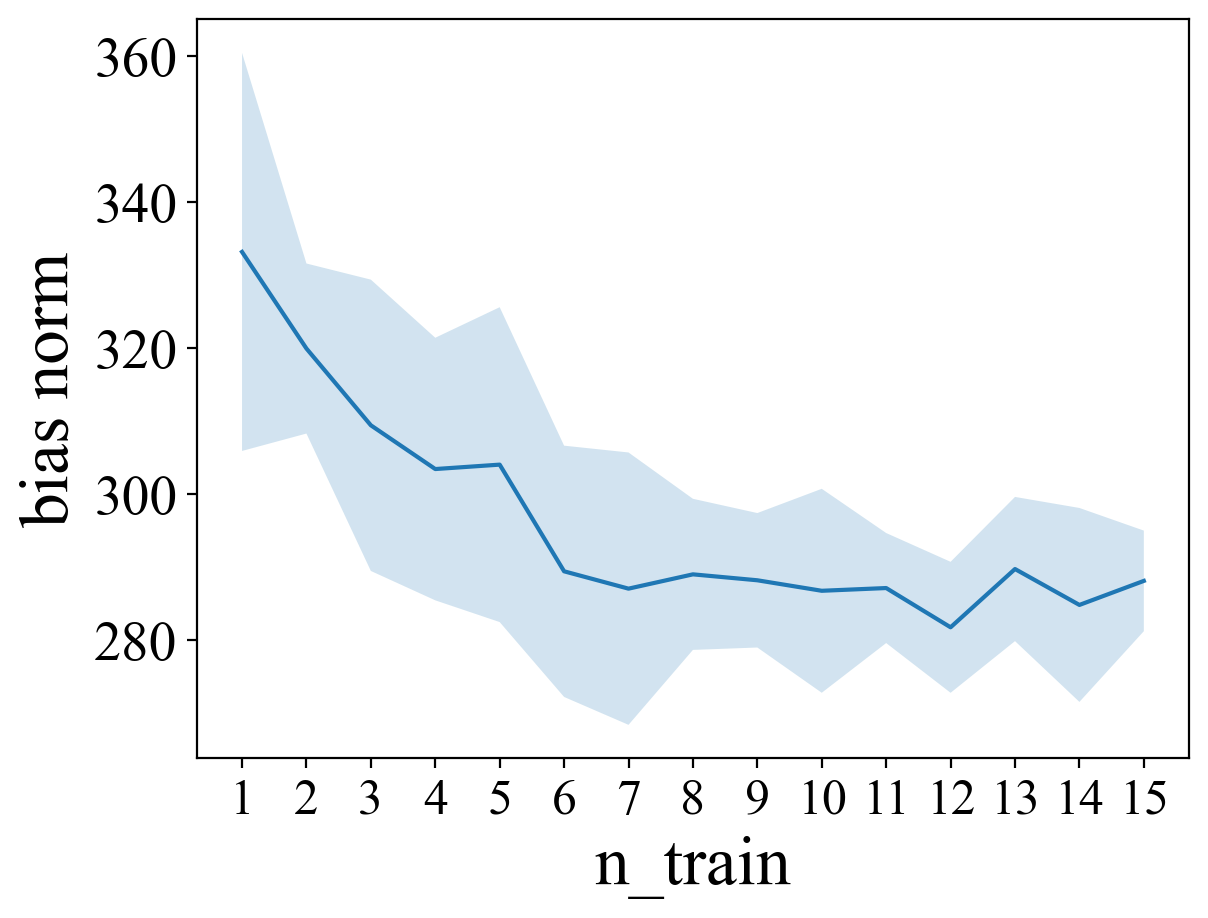

In [39]:
plt.rcdefaults()
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE+5)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################

plt.plot(train_options, means)
plt.fill_between(train_options, means - stds, means + stds, alpha=0.2)
# plt.ylim(bottom = 270)
plt.xticks(train_options)
plt.xlabel("n_train")
plt.ylabel("bias norm")